In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, cross_validate
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import xgboost as xgb
import shap
import matplotlib.pyplot as plt


In [ ]:

# Load dataset
file_path = r"D:\mlpr data\Glioblastoma-ML-model\stackAndModel\merged_data.csv"
df = pd.read_csv(file_path)

# Convert and clean target variable
df["Survival_from_surgery_days_UPDATED"] = pd.to_numeric(df["Survival_from_surgery_days_UPDATED"], errors="coerce")
df.dropna(subset=["Survival_from_surgery_days_UPDATED"], inplace=True)

# Binning into categories
percentiles = np.percentile(df["Survival_from_surgery_days_UPDATED"], [25, 50, 75])
bins = [0, percentiles[0], percentiles[1], percentiles[2], np.inf]
labels = [0, 1, 2, 3]
df["Survival_Category"] = pd.cut(df["Survival_from_surgery_days_UPDATED"], bins=bins, labels=labels)

# Prepare features and labels
X = df.drop(columns=["PatientID", "Survival_from_surgery_days_UPDATED", "Survival_Category"])
y = df["Survival_Category"]

# Encode categorical features
categorical_cols = X.select_dtypes(include=["object"]).columns
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    label_encoders[col] = le

# Fill missing and scale
imputer = SimpleImputer(strategy='median')
scaler = StandardScaler()
X_imputed = imputer.fit_transform(X)
X_scaled = scaler.fit_transform(X_imputed)


In [ ]:

# LDA for visualization & base training (optional)
lda = LinearDiscriminantAnalysis(n_components=3)
X_lda = lda.fit_transform(X_scaled, y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_lda, y, test_size=0.2, random_state=42, stratify=y)

# Balance with SMOTE
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# Base Models
rf_clf = RandomForestClassifier(n_estimators=150, random_state=42)
xgb_clf = xgb.XGBClassifier(n_estimators=200, learning_rate=0.05, max_depth=6, random_state=42, use_label_encoder=False, eval_metric='mlogloss')
log_reg = LogisticRegression(max_iter=1000)
lda_clf = LinearDiscriminantAnalysis()

# Ensemble and Stacking
voting_clf = VotingClassifier(
    estimators=[("RandomForest", rf_clf), ("XGBoost", xgb_clf), ("LogReg", log_reg), ("LDA", lda_clf)],
    voting="hard"
)

stacking_clf = StackingClassifier(
    estimators=[("RandomForest", rf_clf), ("XGBoost", xgb_clf), ("LogReg", log_reg), ("LDA", lda_clf)],
    final_estimator=RandomForestClassifier()
)

# 10-Fold Cross Validation
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

print("Cross-validation scores:")
for model_name, model in [("Voting Classifier", voting_clf), ("Stacking Classifier", stacking_clf)]:
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')
    print(f"{model_name} Accuracy: {scores.mean():.3f} ± {scores.std():.3f}")

# Final training on full training set
voting_clf.fit(X_train, y_train)
stacking_clf.fit(X_train, y_train)

# Final evaluation
y_pred_voting = voting_clf.predict(X_test)
y_pred_stacking = stacking_clf.predict(X_test)

print("\nVoting Classifier Test Report:")
print(classification_report(y_test, y_pred_voting))

print("\nStacking Classifier Test Report:")
print(classification_report(y_test, y_pred_stacking))

C:\Users\asp61\AppData\Local\Temp\ipykernel_57496\1899528196.py:20: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


Cross-validation scores:


c:\Users\asp61\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:24:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\asp61\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:24:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\asp61\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:24:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Voting Classifier Accuracy: 0.950 ± 0.015


c:\Users\asp61\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:24:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\asp61\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:24:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\asp61\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:24:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Stacking Classifier Accuracy: 0.950 ± 0.020


c:\Users\asp61\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:25:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\asp61\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:25:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\asp61\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:25:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are


Voting Classifier Test Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97        33
           1       0.94      0.97      0.95        32
           2       1.00      0.97      0.98        32
           3       1.00      1.00      1.00        32

    accuracy                           0.98       129
   macro avg       0.98      0.98      0.98       129
weighted avg       0.98      0.98      0.98       129


Stacking Classifier Test Report:
              precision    recall  f1-score   support

           0       0.94      0.91      0.92        33
           1       0.94      0.97      0.95        32
           2       1.00      0.94      0.97        32
           3       0.94      1.00      0.97        32

    accuracy                           0.95       129
   macro avg       0.95      0.95      0.95       129
weighted avg       0.95      0.95      0.95       129



c:\Users\asp61\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:25:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_selection import SelectFromModel
from imblearn.over_sampling import SMOTE
import xgboost as xgb
from sklearn.ensemble import StackingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Load dataset
file_path = r"D:\mlpr data\Glioblastoma-ML-model\stackAndModel\merged_data.csv"
df = pd.read_csv(file_path)

# Convert target column to numeric
df["Survival_from_surgery_days_UPDATED"] = pd.to_numeric(df["Survival_from_surgery_days_UPDATED"], errors="coerce")

# Drop rows where target variable is NaN
df = df.dropna(subset=["Survival_from_surgery_days_UPDATED"])

# Percentile-Based Binning
percentiles = np.percentile(df["Survival_from_surgery_days_UPDATED"], [25,50,75])
bins = [0, percentiles[0], percentiles[1],  percentiles[2], np.inf]
labels = [0, 1, 2,3]

df["Survival_Category"] = pd.cut(df["Survival_from_surgery_days_UPDATED"], bins=bins, labels=labels)

# Separate features (X) and target (y)
X = df.drop(columns=["PatientID", "Survival_from_surgery_days_UPDATED", "Survival_Category"])
y = df["Survival_Category"]

# Encode categorical columns
categorical_cols = X.select_dtypes(include=["object"]).columns
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    label_encoders[col] = le

# Fill missing numeric values with median
X = X.apply(pd.to_numeric, errors="coerce").fillna(X.median())

# Standardize numeric features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply LDA for dimensionality reduction
lda = LinearDiscriminantAnalysis(n_components=3)  # Adjust components based on the number of classes - 1
X_lda = lda.fit_transform(X_scaled, y)

# Train-test split (80:20)
X_train, X_test, y_train, y_test = train_test_split(X_lda, y, test_size=0.2, random_state=42, stratify=y)

# Balance Classes with SMOTE
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# Define Base Models
rf_clf = RandomForestClassifier(n_estimators=150, random_state=42)
xgb_clf = xgb.XGBClassifier(n_estimators=200, learning_rate=0.05, max_depth=6, random_state=42)
log_reg = LogisticRegression(max_iter=1000)
lda_clf = LinearDiscriminantAnalysis()

# Voting Classifier (Soft Voting for Probabilistic Averaging)
ensemble_model = VotingClassifier(
    estimators=[("RandomForest", rf_clf), ("XGBoost", xgb_clf), ("LogReg", log_reg), ("LDA", lda_clf)],
    voting="hard"
)

# Stacking Classifier
stacking_clf = StackingClassifier(
    estimators=[("RandomForest", rf_clf), ("XGBoost", xgb_clf), ("LogReg", log_reg), ("LDA", lda_clf)],
    final_estimator=RandomForestClassifier()
)

# Train the models
stacking_clf.fit(X_train, y_train)
ensemble_model.fit(X_train, y_train)

# Predictions
y_pred_ensemble = ensemble_model.predict(X_test)
y_pred_stacking = stacking_clf.predict(X_test)

# Evaluate the models
accuracy_ensemble = accuracy_score(y_test, y_pred_ensemble)
accuracy_stacking = accuracy_score(y_test, y_pred_stacking)

report_ensemble = classification_report(y_test, y_pred_ensemble)
report_stacking = classification_report(y_test, y_pred_stacking)

print(f"Ensemble Model Accuracy with LDA: {accuracy_ensemble:.2f}")
print("Classification Report:\n", report_ensemble)

print(f"Stacking Model Accuracy with LDA: {accuracy_stacking:.2f}")
print("Classification Report:\n", report_stacking)

C:\Users\asp61\AppData\Local\Temp\ipykernel_57496\1160533738.py:17: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


Ensemble Model Accuracy with LDA: 0.98
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97        33
           1       0.94      0.97      0.95        32
           2       1.00      0.97      0.98        32
           3       1.00      1.00      1.00        32

    accuracy                           0.98       129
   macro avg       0.98      0.98      0.98       129
weighted avg       0.98      0.98      0.98       129

Stacking Model Accuracy with LDA: 0.96
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.94      0.94        33
           1       0.94      0.97      0.95        32
           2       1.00      0.94      0.97        32
           3       0.97      1.00      0.98        32

    accuracy                           0.96       129
   macro avg       0.96      0.96      0.96       129
weighted avg       0.96      0.96      0.96       129



In [5]:
from sklearn.metrics import balanced_accuracy_score

# Balanced Accuracy
balanced_acc_ensemble = balanced_accuracy_score(y_test, y_pred_ensemble)
balanced_acc_stacking = balanced_accuracy_score(y_test, y_pred_stacking)

print(f"Balanced Accuracy (Ensemble): {balanced_acc_ensemble:.2f}")
print(f"Balanced Accuracy (Stacking): {balanced_acc_stacking:.2f}")


Balanced Accuracy (Ensemble): 0.98
Balanced Accuracy (Stacking): 0.95


In [6]:
from lifelines.utils import concordance_index

# Get original survival times for y_test samples
# Make sure the test set index aligns with the original dataframe
true_survival_times = y_test.copy()
true_survival_times = df.loc[y_test.index, "Survival_from_surgery_days_UPDATED"]

# Define bin midpoints (same binning as earlier)
bin_midpoints = [(bins[i] + bins[i+1]) / 2 for i in range(len(bins) - 1)]

# Map predicted categories to survival time estimates
pred_survival_ensemble = [bin_midpoints[int(label)] for label in y_pred_ensemble]
pred_survival_stacking = [bin_midpoints[int(label)] for label in y_pred_stacking]

# Compute Concordance Index
c_index_ensemble = concordance_index(true_survival_times, pred_survival_ensemble)
c_index_stacking = concordance_index(true_survival_times, pred_survival_stacking)

print(f"Concordance Index (Ensemble): {c_index_ensemble:.2f}")
print(f"Concordance Index (Stacking): {c_index_stacking:.2f}")


Concordance Index (Ensemble): 0.87
Concordance Index (Stacking): 0.85


 99%|===================| 2550/2576 [02:40<00:01]        

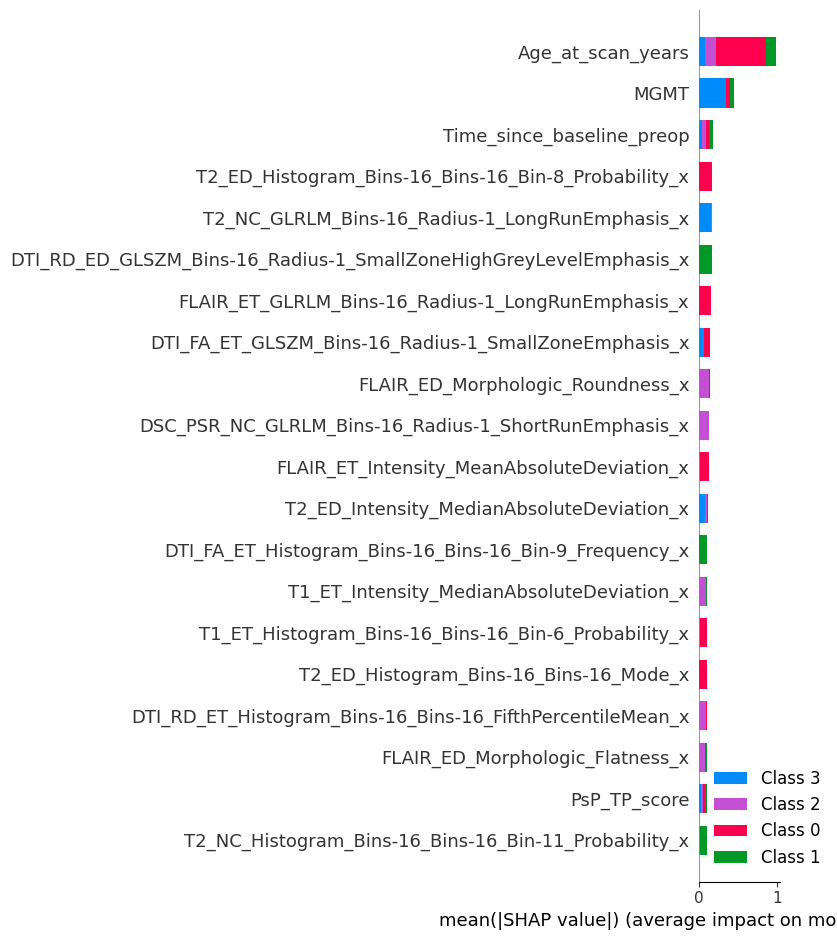

ValueError: The waterfall plot can currently only plot a single explanation, but a matrix of explanations (shape (644, 9514, 4)) was passed! Perhaps try `shap.plots.waterfall(shap_values[0])` or for multi-output models, try `shap.plots.waterfall(shap_values[0, 0])`.

In [10]:
import shap

# Use original scaled data, not LDA-transformed (SHAP needs original features)
# So we'll fit one model (e.g., XGBoost) on X_scaled instead of X_lda
xgb_clf.fit(X_scaled, y)  # Refit on full data or use X_train if preferred

# Create SHAP explainer
explainer = shap.Explainer(xgb_clf, X_scaled)
shap_values = explainer(X_scaled)

# Plot global feature importance
shap.summary_plot(shap_values, X, plot_type="bar")

# Plot a single prediction explanation
shap.plots.waterfall(shap_values)

In [ ]:
import eli5
from eli5.sklearn import explain_weights, explain_prediction

# For logistic regression model
eli5.show_weights(log_reg, feature_names=X.columns.tolist())


ValueError: Can't figure out feature vector size for LogisticRegression(max_iter=1000)